In [65]:
import re
import pandas as pd
import numpy as np
import tensorflow as tf
import math
import nltk
import matplotlib.pyplot as plt
import os
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Embedding

from datetime import datetime

In [18]:
data = pd.read_csv('IMDB Dataset.csv')

In [19]:
def sentimentHistogram(data):
    positive_reviews = data[data['sentiment'] == 'positive']
    negative_reviews = data[data['sentiment'] == 'negative']

    positive_count = len(positive_reviews)
    negative_count = len(negative_reviews)
    
    # Data for the plot
    labels = ['Positive', 'Negative']
    counts = [positive_count, negative_count]

    # Create the plot
    plt.bar(labels, counts)
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.title('Number of Positive and Negative Reviews')

    # Display the plot
    plt.show()

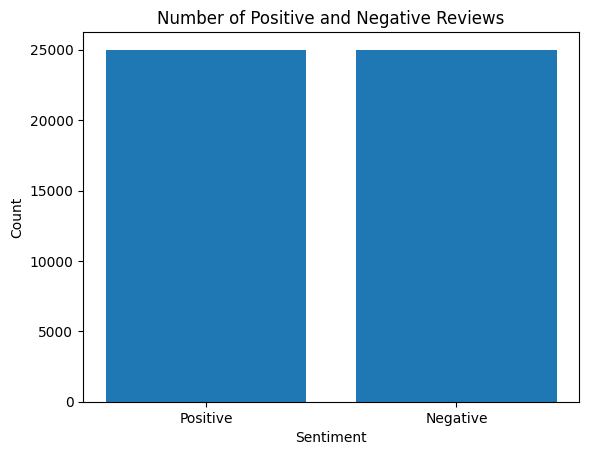

In [20]:
sentimentHistogram(data)

In [21]:
def lemmatize_text(text):
    st = ""
    for w in w_tokenizer.tokenize(text):
        st = st + lemmatizer.lemmatize(w) + " "
    return st

In [22]:
def reviewPreprocessing(review):
    # Remove HTML tags
    review = re.sub('<.*?>', '', review)
    
    # Remove URLs
    review = re.sub(r'http\S+|www\.\S+', '', review)
    
    # Remove non-alphanumeric characters
    review = re.sub(r'[^a-zA-Z0-9\s]', '', review)
    
    # Convert to lowercase
    review = review.lower()
    
    # Remove stopwords
    with open('stopwords.txt', 'r') as f:
        stopwords = set(f.read().split('\n'))
    
    review = ' '.join(word for word in review.split() if word not in stopwords)
    
    return review

In [23]:
data['review'] = data['review'].apply(reviewPreprocessing)
# Perform lemmatization on the text
#nltk.download('wordnet')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
data['review'] = data.review.apply(lemmatize_text)
data

,review,sentiment
0,one reviewer mentioned watching 1 oz episode y...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically there family little boy jake think t...,negative
4,petter matteis love time money visually stunni...,positive
...,...,...
49995,thought movie right good job wasnt creative or...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,catholic taught parochial elementary school nu...,negative
49998,im going disagree previous comment side maltin...,negative


In [24]:
reviews = data['review'].values
labels = data['sentiment'].values
encoder = LabelEncoder()
encoded_labels = (labels == 'positive').astype(int)

In [25]:
encoded_labels

array([1, 1, 1, ..., 0, 0, 0])

In [26]:
train_sentences, rest_sentences, train_labels, rest_labels = train_test_split(
    reviews, 
    encoded_labels, 
    train_size=0.8, 
    random_state=42, stratify=encoded_labels)

# Split the training data into training and validation sets (80/10/10 split)
test_sentences, val_sentences, test_labels, val_labels = train_test_split(rest_sentences, 
                                                                    rest_labels, 
                                                                    test_size=0.5, 
                                                                    random_state=42)

In [27]:
# Hyperparameters of the model
vocab_size = 3000 # choose based on statistics
oov_tok = ''
embedding_dim = 100
max_length = 250 # choose based on statistics, for example 150 to 200
padding_type='post'
trunc_type='post'

# tokenize sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

# convert train dataset to sequence and pad sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)

# convert Test dataset to sequence and pad sequences
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

# convert validation dataset to sequence and pad sequences
val_sequences = tokenizer.texts_to_sequences(val_sentences)
val_padded = pad_sequences(val_sequences, padding='post', maxlen=max_length)

In [51]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(1, activation='sigmoid'))

In [52]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

In [53]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 250, 100)          300000    
                                                                 
 lstm_9 (LSTM)               (None, 250, 32)           17024     
                                                                 
 lstm_10 (LSTM)              (None, 250, 64)           24832     
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dense_6 (Dense)             (None, 64)                2112      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 1)                

In [55]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
batch_size = 32

epochs = 1000
history = model.fit(train_padded, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(
    val_padded, val_labels), verbose=1, callbacks=[early_stopping])


Epoch 1/1000
1250/1250 [==============================] - 72s 58ms/step - loss: 0.6830 - accuracy: 0.5273 - val_loss: 0.6940 - val_accuracy: 0.5036
Epoch 2/1000
1250/1250 [==============================] - 71s 57ms/step - loss: 0.6706 - accuracy: 0.5476 - val_loss: 0.6510 - val_accuracy: 0.5872
Epoch 3/1000
1250/1250 [==============================] - 72s 57ms/step - loss: 0.5642 - accuracy: 0.6940 - val_loss: 0.5324 - val_accuracy: 0.7636
Epoch 4/1000
1250/1250 [==============================] - 72s 57ms/step - loss: 0.4493 - accuracy: 0.7979 - val_loss: 0.4511 - val_accuracy: 0.7934
Epoch 5/1000
1250/1250 [==============================] - 72s 57ms/step - loss: 0.4266 - accuracy: 0.8298 - val_loss: 0.4176 - val_accuracy: 0.8344
Epoch 6/1000
1250/1250 [==============================] - 71s 57ms/step - loss: 0.4547 - accuracy: 0.8007 - val_loss: 0.4412 - val_accuracy: 0.7928
Epoch 7/1000
1250/1250 [==============================] - 72s 58ms/step - loss: 0.3875 - accuracy: 0.8336 - val_

In [56]:
prediction = model.predict(test_padded)
# Get labels based on probability 1 if p>= 0.5 else 0
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
print("Accuracy of prediction on test set : ", accuracy_score(test_labels,pred_labels))

157/157 [==============================] - 5s 27ms/step
Accuracy of prediction on test set :  0.8816


In [57]:
performance = model.evaluate(test_padded, test_labels)
print('Test Set Loss: {:0.3f}\nTest Set Accuracy: {:0.4f}'.format(performance[0],performance[1]))

157/157 [==============================] - 5s 29ms/step - loss: 0.3096 - accuracy: 0.8816
Test Set Loss: 0.310
Test Set Accuracy: 0.8816


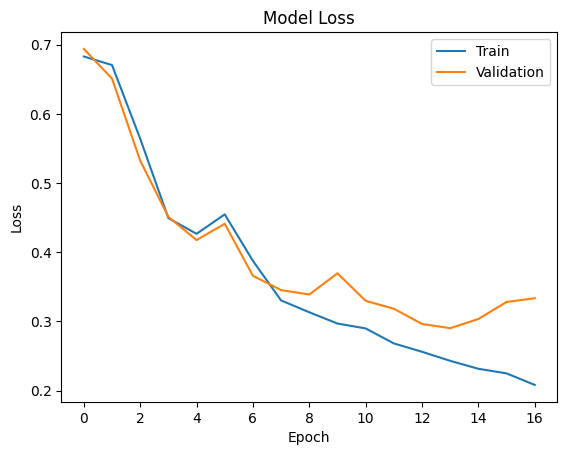

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

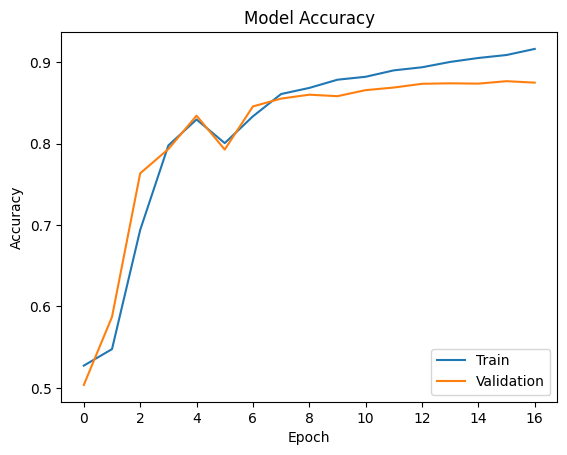

In [59]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [60]:
# reviews on which we need to predict
sentence = ["The movie was very touching and heart whelming", 
            "I have never seen a terrible movie like this", 
            "the movie plot is terrible but it had good acting"]
# convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)
# pad the sequence
padded = pad_sequences(sequences, padding='post', maxlen=max_length)
# Get labels based on probability 1 if p>= 0.5 else 0
prediction = model.predict(padded)
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
for i in range(len(sentence)):
    print(sentence[i])
    if pred_labels[i] == 1:
        s = 'Positive'
    else:
        s = 'Negative'
    print("Predicted sentiment : ",s)

1/1 [==============================] - 0s 40ms/step
The movie was very touching and heart whelming
Predicted sentiment :  Positive
I have never seen a terrible movie like this
Predicted sentiment :  Negative
the movie plot is terrible but it had good acting
Predicted sentiment :  Negative


In [63]:
# Define a unique model name based on the current timestamp
model_name = f'model_{str(datetime.now().strftime("%Y%m%d_%H%M%S"))}.h5'
model_path = os.path.join('LSTM Models', model_name)
# Save the trained model
model.save(model_path)
print(f"Trained model saved at: {model_path}")

Trained model saved at: LSTM Models\model_20230607_205656.h5


In [69]:
# Save the tokenizer with a unique filename
tokenizer_file = f'tokenizer_{str(datetime.now().strftime("%Y%m%d_%H%M%S"))}.pkl'
os.makedirs('LSTM Tokenizer')
tokenizer_path = os.path.join('LSTM Tokenizer', tokenizer_file)

# Save the tokenizer
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)
print(f"Trained model saved at: {model_path}")

Trained model saved at: LSTM Models\model_20230607_205656.h5
